# Image Classification using Transfer Learning
We will classify images of cats and dogs using transfer learning models such as Inception, ResNet and VGGNet. 

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import imagenet_utils
   

# Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press Enter;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called sciml-workshop-data should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [4]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Couldn't find program: 'bash'


# Add label to each image

This is a data preprocessing step which ensures a proper label is added to each image name. 

In [5]:
def image_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        image_name += '.jpg'
        if image_name[0].lower() != image_name[0]:
            class_name = 'cat'
        else:
            class_name = 'dog'
        annotations[image_name] = class_name
    
    return annotations, i + 1


class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_path = os.path.join(data_path,'annotations/trainval.txt')
test_path = os.path.join(data_path,'annotations/test.txt')

train_annot, count_train = image_annotations(train_path)
test_annot, count_test = image_annotations(test_path)

print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


# Select images randomly

A function is defined which is used to randomly choose images of given batch size.

In [6]:
image_dir = os.path.join(data_path,'images')

def get_random_batch(annot,model_name, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, all_keys[index]),
                                                     target_size=(128, 128))
        images.append(image)
        arr = tf.keras.preprocessing.image.img_to_array(image)
        if model_name == 'inception':
            arr = tf.keras.applications.inception_v3.preprocess_input(arr)
        elif model_name == 'vgg16' or model_name == 'resnet':  
            arr = imagenet_utils.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
    
    return x, y, images

# Load pre-trained model

Here we load a pre-trained model from Keras. The model is specified using the variable model_name. 

In [32]:
MODELS = {
"inception": InceptionV3,
"resnet": ResNet50,
"vgg16": VGG16 }

model_name = 'inception'
Network = MODELS[model_name]

base_model = Network(weights='imagenet', include_top=False,input_shape=(128, 128, 3), pooling='avg')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

# Display images

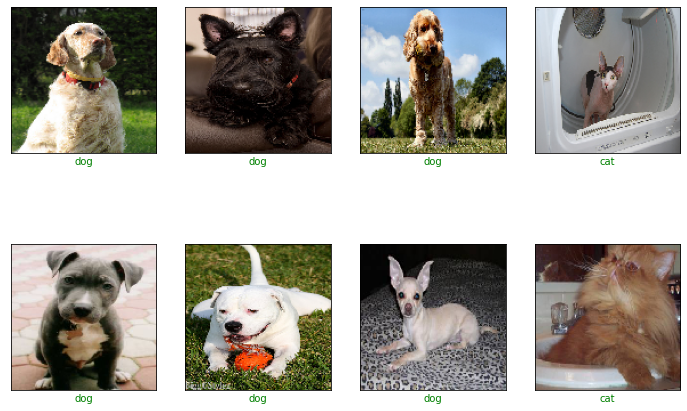

In [33]:
def display_images(x, y, p, images, index_to_class):
    
    if len(images) < 8:
        print('Need at least 8 examples')
        return None

    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        gt = int(np.squeeze(y[i]) > 0.5)
        pred = int(np.squeeze(p[i]) > 0.5)
        col = 'green' if gt == pred else 'red'
        plt.xlabel(index_to_class[pred], color=col)
    return plt

x, y, images = get_random_batch(train_annot,model_name, batch_size=8)
display_images(x, y, y, images, index_to_class).show()

# Build and compile model

In [34]:
def create_model():
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot,model_name, batch_size)
        yield (x, y)

In [36]:
batch_size = 32
steps_per_epoch = int(len(list(train_annot.keys()))/batch_size)
validation_steps = int(len(list(test_annot.keys()))/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)


Steps per epoch: 115
Validation steps: 114


# Train model

In [37]:
%%time

H = model.fit(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

115/115 [==============================] - 136s 1s/step - loss: 0.5099 - acc: 0.8554 - val_loss: 0.2005 - val_acc: 0.9328
Wall time: 2min 23s


# Make predictions

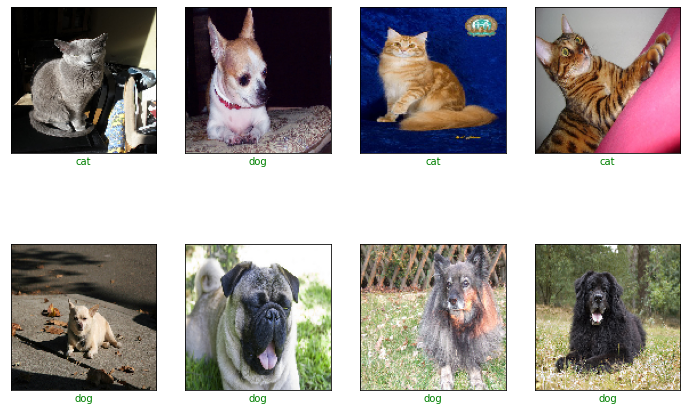

In [31]:
x, y, images = get_random_batch(test_annot,model_name, batch_size=8)
preds = model.predict(x)
display_images(x, y, preds, images, index_to_class).show()